In [1]:
""" Setup the environment for the notebook """
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils.stock_loader as stock_loader

""" Importlib is used to reload the module after changes.
    This is useful when developing the module and testing it in the notebook.
    The reload is done by running the cell again.

    REMEMBER TO ADD THE MODULE BELOW FOR RELOADING.
"""


import es.es_factory
import utils.es_logger

import importlib
importlib.reload(stock_loader)
importlib.reload(es.es_factory)
importlib.reload(utils.es_logger)

from es.es_factory import ESFactory
from utils.es_logger import ESLogger

/Users/seanjensen/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [33]:
""" Data Requirements:
Data Source:    Yahoo Finance
Data Type:      Historical Daily Stock Prices
Data Period:    01/01/2018 - 12/31/2022
Data Columns:   Date, Open, High, Low, Close, Volume (Can be more).
Description:    Need to have 20 different stocks to analyze and
    compute monthly returns.
"""

DATA_PERIOD = {
    'start': datetime.datetime(2018, 1, 1),
    'end': datetime.datetime(2022, 12, 31),
    'period': '1d',
}

STOCK_TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NOD.OL', 'NVDA', 'TSLA', 'UAA', 'SNAP', 'TEL.OL', 'MPCC.OL', 'AKAST.OL', 'BA', 'ADBE', 'ORCL', 'NTDOY', 'PCG', 'KHC', 'SONY']
stock_data = pd.DataFrame({ticker: stock_loader.load_or_download_stock_data(ticker, **DATA_PERIOD) for ticker in STOCK_TICKERS})
monthly_returns = stock_data.resample('ME').last().pct_change().dropna()

print(f"Number of stocks: {len(monthly_returns.columns)}")

Number of stocks: 19


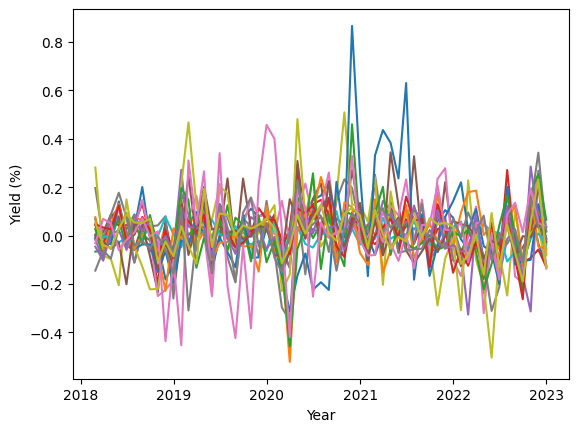

In [34]:
plt.plot(monthly_returns)
plt.xlabel("Year")
plt.ylabel("Yield (%)")
plt.show()

In [35]:
from es.types import ESType
from typing import Callable
from es.strategy import Strategy

def run_for(get_strategy: Callable[[], Strategy], times: int, generations: int, logger: ESLogger):
    all_p = pd.DataFrame()
    for run in range(times):
        population = get_strategy()
        population.fit(generations=generations, logger=logger)
        best_portfolio = population._population[0]

        assert len(best_portfolio.chromosone) == len(STOCK_TICKERS)

        portfolio = {ticker: value for ticker, value in zip(STOCK_TICKERS, best_portfolio.chromosone)}
        portfolio['returns'] = best_portfolio.fitness
        
        # Calculate portfolio risk using the covariance matrix of monthly returns
        weights = np.array(best_portfolio.chromosone)
        cov_matrix = monthly_returns.cov()
        portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
        portfolio['risk'] = np.sqrt(portfolio_variance)
        
        portfolio_df = pd.DataFrame(portfolio, index=[run])
        all_p = pd.concat([all_p, portfolio_df])
    
    plt.plot(all_p['returns'], c='green')
    plt.plot(all_p['risk'], c='red')
    plt.show()

    return all_p

def plot_weights(data: pd.DataFrame):
    rows = data.shape[0]
    for run in range(rows):
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Extract data for the current run
        run_data = data.iloc[run]
        
        # Create the histogram
        ax.bar(STOCK_TICKERS, run_data[STOCK_TICKERS])
        
        ax.set_xlabel('Stock Tickers')
        ax.set_ylabel('Weight')
        ax.set_title(f'Stock Weights for Run {run + 1}')
        
        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45, ha='right')
        
        # Add value labels on top of each bar
        for i, v in enumerate(run_data[STOCK_TICKERS]):
            ax.text(i, v, f'{v:.4f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

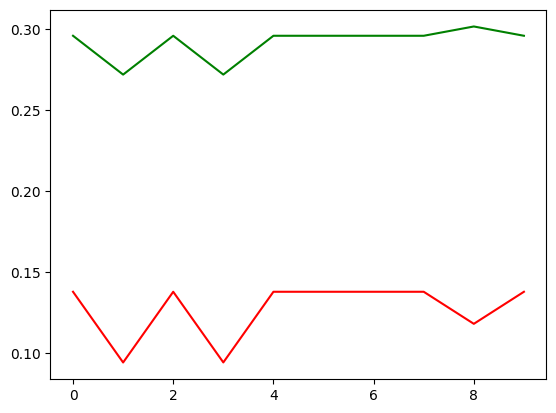

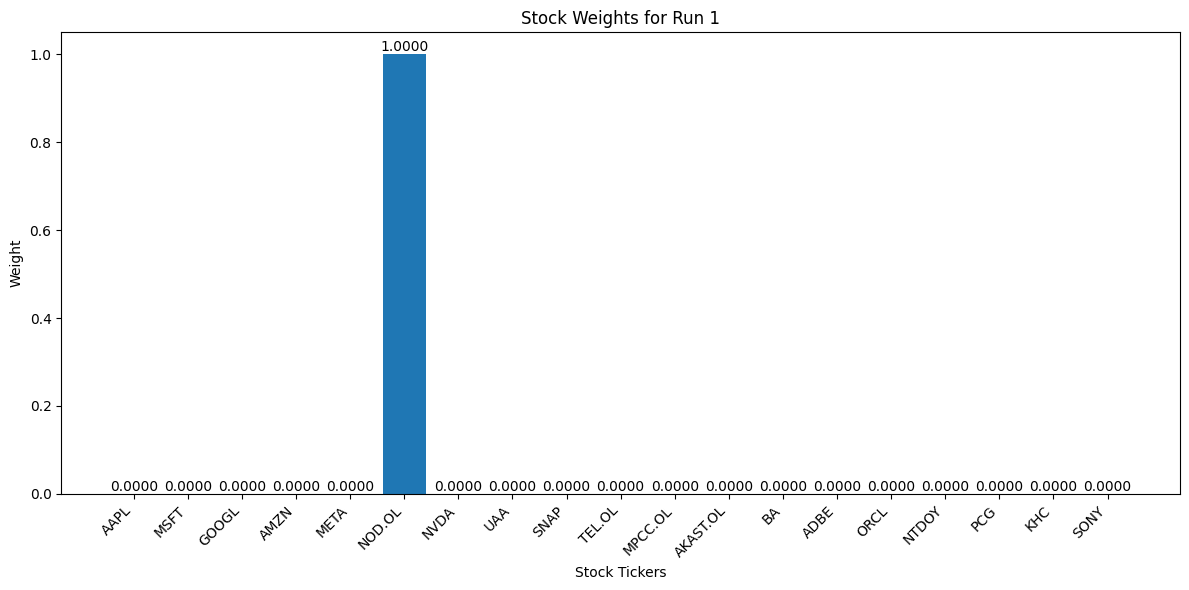

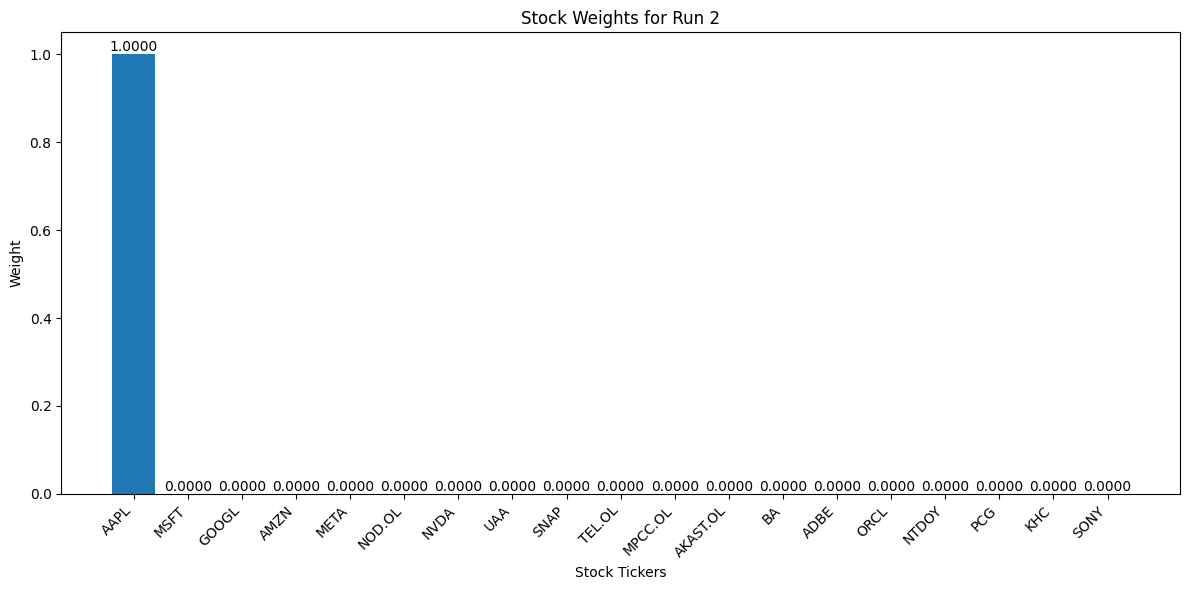

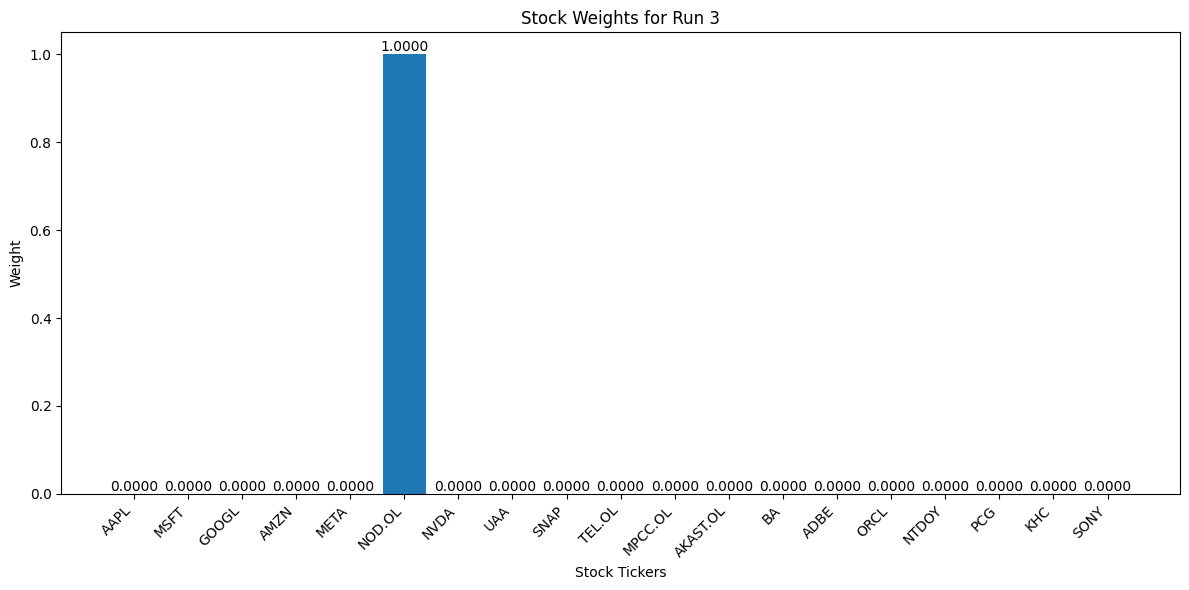

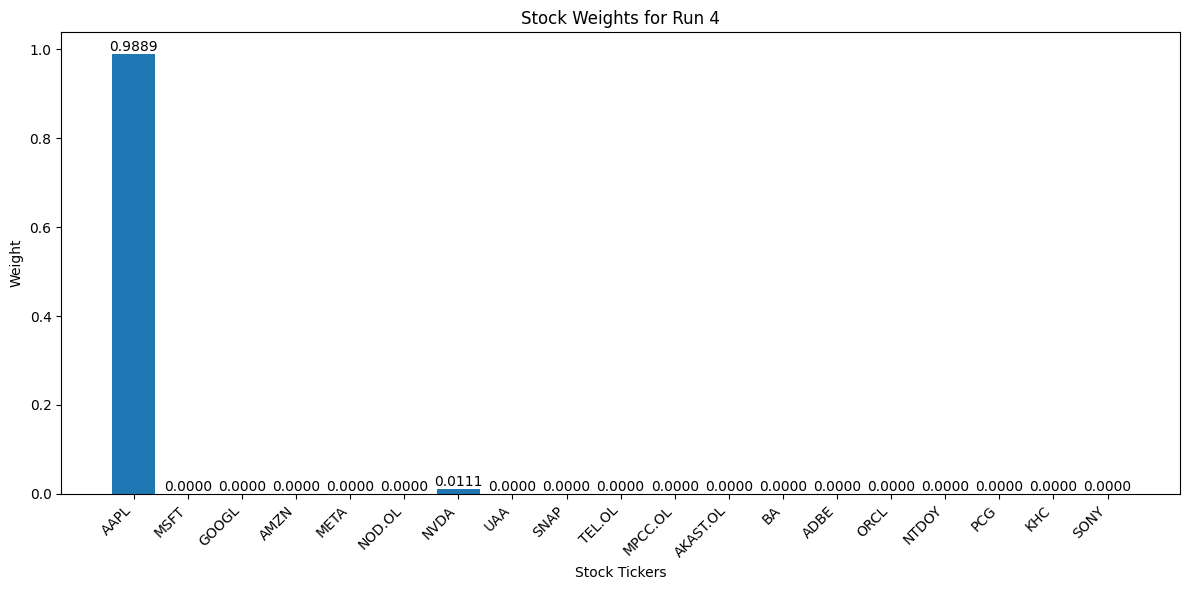

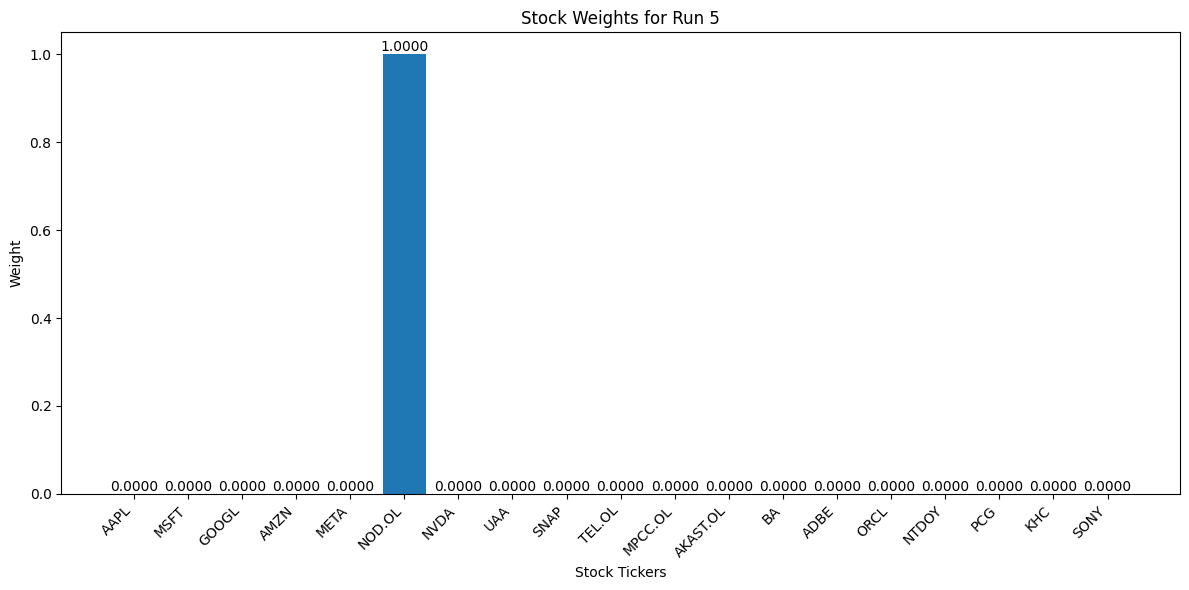

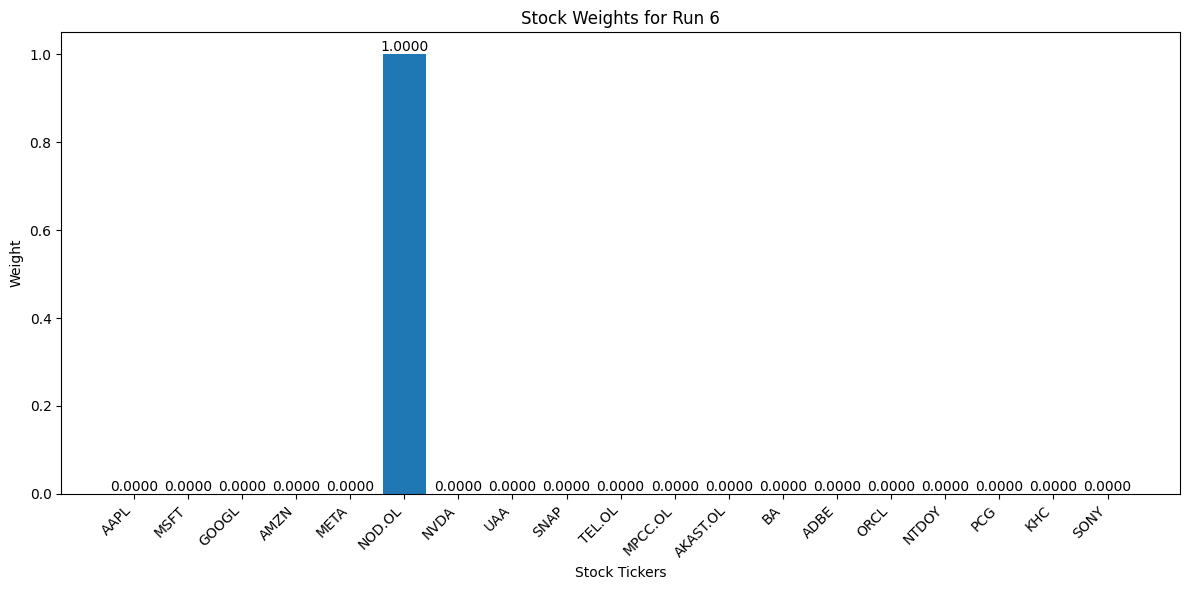

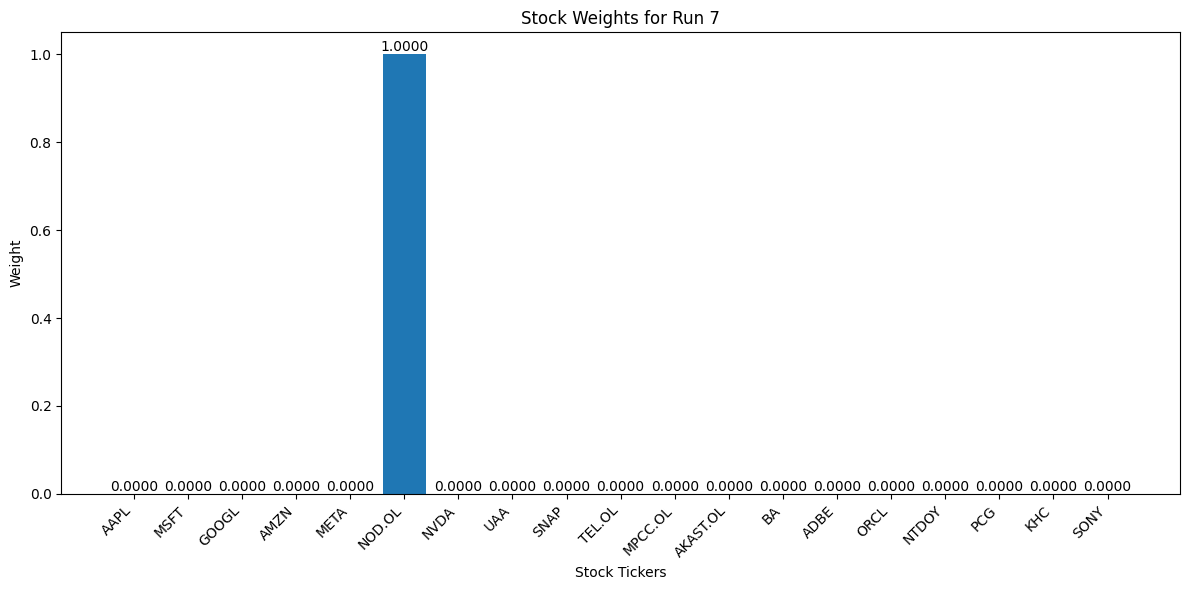

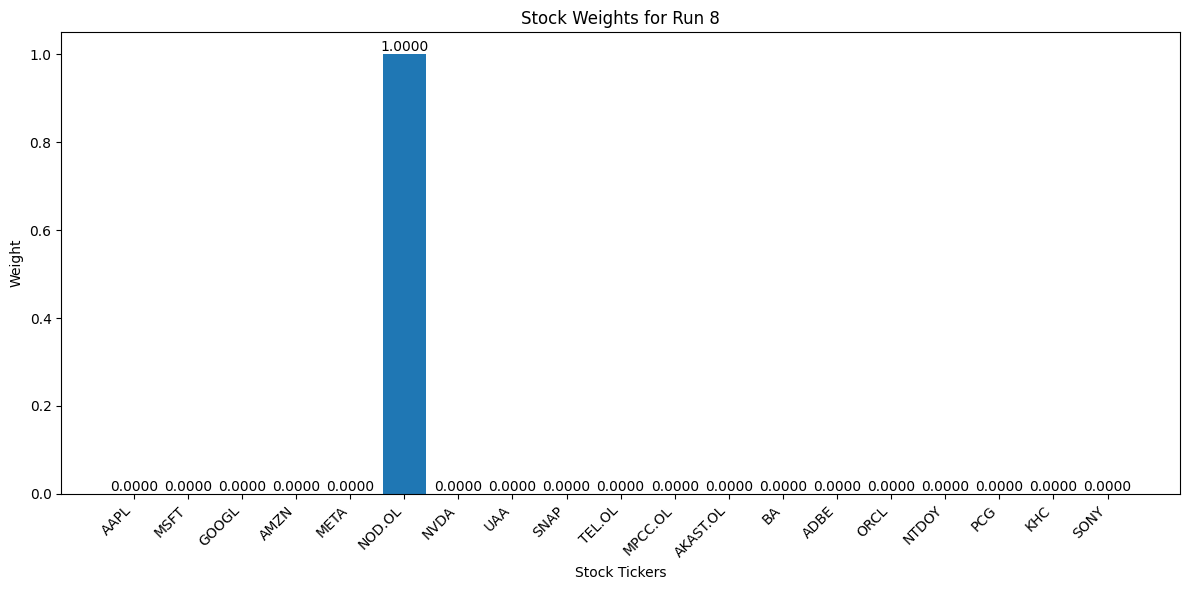

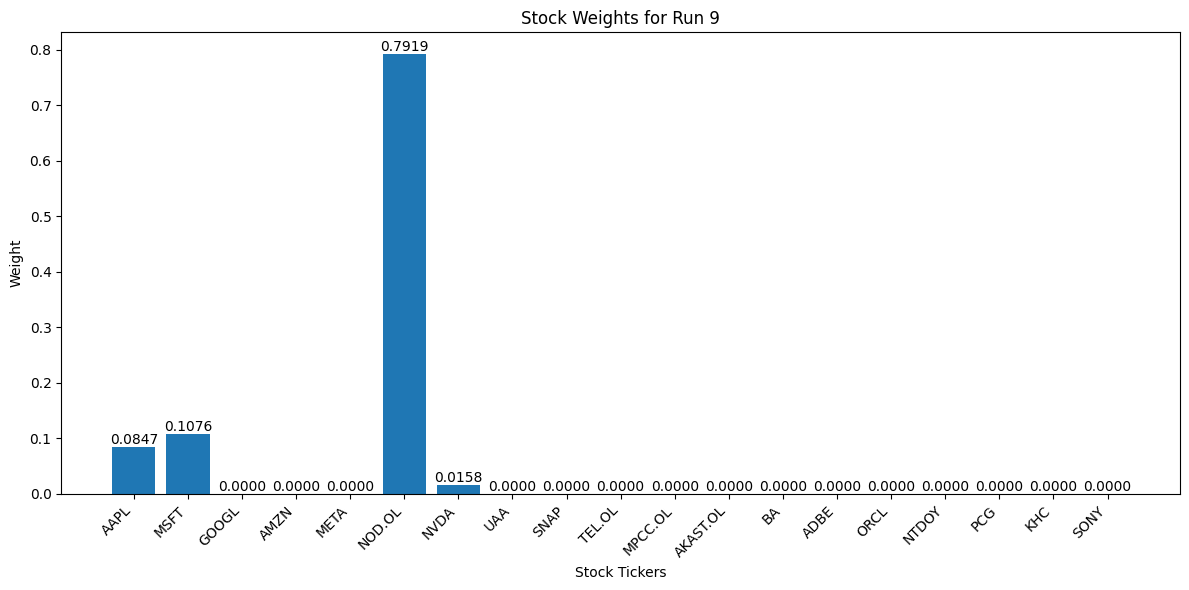

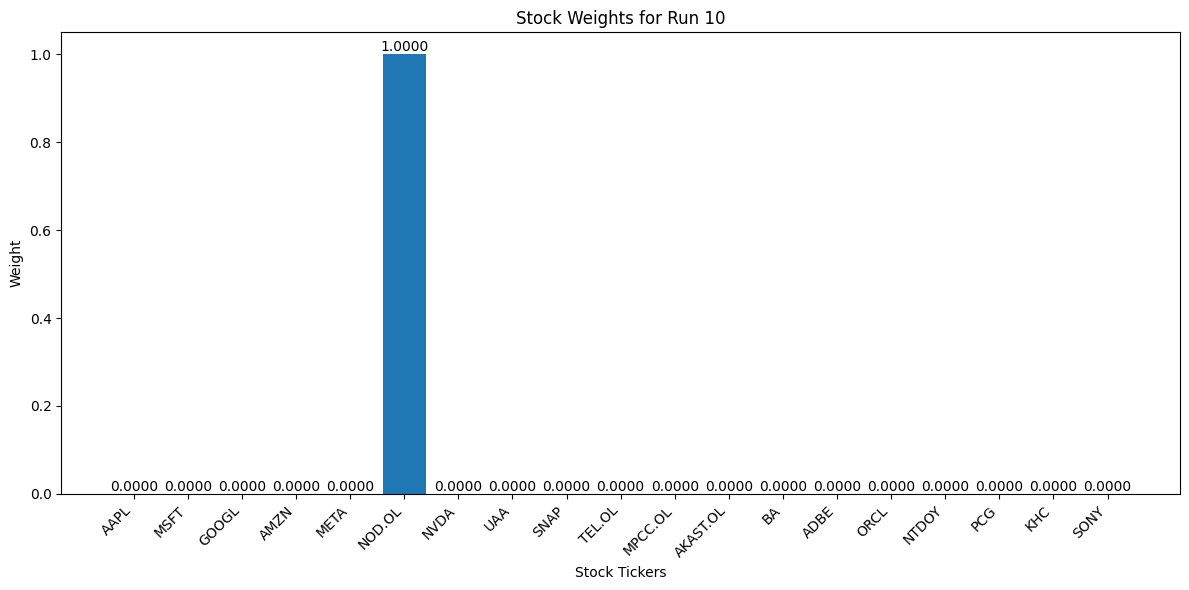

In [36]:
logger = ESLogger(verbose=False)
factory = ESFactory(monthly_returns=monthly_returns)

advanced_one = lambda: factory.create_basic(steps=1, population_size=100, offspring_size=700)
data = run_for(advanced_one, 10, 10, logger)
plot_weights(data)

In [19]:

advanced_n = lambda: factory.create_advanced(
    ESType.MuPlusLambda,
    steps=len(STOCK_TICKERS), population_size=10, offspring_size=70)

portfolio_df = run_for(advanced_n, 10, 40, logger)
portfolio_df.head()


,AAPL,MSFT,GOOGL,AMZN,META,NOD.OL,NVDA,TSLA,UAA,SNAP,...,MPCC.OL,AKAST.OL,BA,ADBE,ORCL,NTDOY,PCG,KHC,SONY,returns
0,0.108287,0.067328,0.000000,0.00000,0.00000,0.241565,0.088878,0.460410,0.000000,0.025212,...,0.000000,0.003689,0.0,0.0,0.000000,0.0,0.000000,0.0,0.004631,0.398957
1,0.018370,0.000000,0.020794,0.04272,0.00000,0.270813,0.346971,0.264845,0.010963,0.024525,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.337335
2,0.000000,0.103546,0.000000,0.00000,0.00000,0.088073,0.000000,0.788037,0.000000,0.002763,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.017581,0.0,0.000000,0.409438
3,0.000000,0.036387,0.000000,0.00000,0.00000,0.388799,0.000000,0.473057,0.000000,0.000000,...,0.010961,0.003135,0.0,0.0,0.029803,0.0,0.033519,0.0,0.000000,0.396440
4,0.227944,0.094229,0.000000,0.00000,0.02736,0.262672,0.134881,0.207986,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.030291,0.0,0.000000,0.329826


[Log] {'generation': 0, 'max_fitness': 0.253330804388642, 'mean_fitness': 0.10712516133627133, 'n_offsprings': 700}
[Log] {'generation': 1, 'max_fitness': 0.3040680916448737, 'mean_fitness': 0.1440183891283181, 'n_offsprings': 700}
[Log] {'generation': 2, 'max_fitness': 0.29468315583505866, 'mean_fitness': 0.16715516569910097, 'n_offsprings': 700}
[Log] {'generation': 3, 'max_fitness': 0.33523533450128973, 'mean_fitness': 0.18513487466142212, 'n_offsprings': 700}
[Log] {'generation': 4, 'max_fitness': 0.33523533450128973, 'mean_fitness': 0.20413758782277247, 'n_offsprings': 700}
[Log] {'generation': 5, 'max_fitness': 0.36651581507444453, 'mean_fitness': 0.21890580706614096, 'n_offsprings': 700}
[Log] {'generation': 6, 'max_fitness': 0.37761635553037065, 'mean_fitness': 0.23616768694261514, 'n_offsprings': 700}
[Log] {'generation': 7, 'max_fitness': 0.3926212160724618, 'mean_fitness': 0.2493237163164585, 'n_offsprings': 700}
[Log] {'generation': 8, 'max_fitness': 0.3943105696093405, 'me

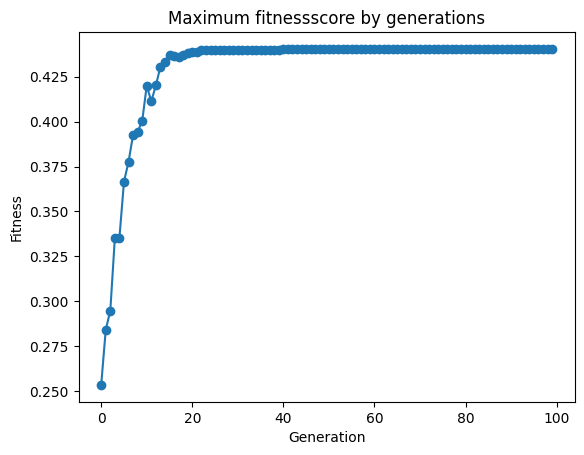

In [ ]:
advanced_n = factory.create_advanced(
    ESType.MuCommaLambda,
    steps=len(STOCK_TICKERS), population_size=100, offspring_size=700) \
    .fit(generations=100, logger=logger)
logger.flush()